<a href="https://www.kaggle.com/code/giuliobenedetti/alzheimer-s-disease-prediction?scriptVersionId=159759709" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In this notebook, we aim to predict the Clinical Dementia Rating scores (CDR) of individuals with Alzheimer's Disease (AD) in a cross-sectional and longitudinal study design with several Machine Learning (ML) and Neural Network (NN) approaches. For this purpose, we analysed two datasets belonging to the [Open Access Series of Imaging Studies](https://www.oasis-brains.org/) (OASIS):

- OASIS-I, a cross-sectional dataset with 416 subjects (Marcus et al., 2007)
- OASIS-II, a longitudinal dataset with 150 subjects (Marcus et al., 2010)

The two datasets are stored in Kaggle as [MRI and Alzheimers](https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers) and can be imported as follows along with a few analytical modules.

In [1]:
# Import packages
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Load data
df_cross = pd.read_csv("/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv")
df_long = pd.read_csv("/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv")

# Preliminary Exploration

In this first section, we clean the data and visually explore its patterns. 

## Data Cleaning

In [2]:
# Rename cols to match names in df_cross
df_long = df_long.rename(columns={"MRI ID": "ID", "EDUC": "Educ", "MR Delay": "Delay"})

# Create columns for easy distinction between the cohorts
df_cross["Cohort"] = "OASIS1"
df_long["Cohort"] = "OASIS2"

# Concatenate df_cross with df_long
df = pd.concat([df_cross, df_long])

# Drop rows with missing target variable
df.dropna(subset=["CDR"], inplace=True)

# Remove cols with only one distinct value
df.drop(["Hand"], axis=1, inplace=True)

# Use ID as row index
df.index = df.pop("ID")

The target variable (CDR) is conventionally categorised into five levels, of which only the first four are available in our data:

| Condition            | CDR |
|----------------------|:---:|
| Healthy              | 0   |
| Very mildly demented | 0.5 |
| Mildly demented      | 1   |
| Moderately demented  | 2   |
| Severely demented    | 3   |

However, we binarise the target variable (CDR) as healthy vs demented, reducing the problem to a binary classification task. This simplifies model design as well as the assessment of its performance and partially solves the issue of class imbalance.

In [3]:
# Binarise target variable
df["CDR"] = df["CDR"].map({0: 0, 0.5: 1, 1: 1, 2: 1, 3: 1})

# Split preprocessed datasets
df_cross = df.loc[df["Cohort"] == "OASIS1", ]
df_long = df.loc[df["Cohort"] == "OASIS2", ]

## Visualisation

### Cross-sectional dataset

First exploratory plots on the cross-sectional data set OASIS-I show that of the remaining 235 participants, most were female (Female: 156; Male: 79) with the largest gender imbalance in the control group. Among the non-demented subjects, the mode for SES was 2 while for the demented group the mode for SES was 4. The mode on the education variable for non-demented participants was 5 while it was 2 for demented participants.

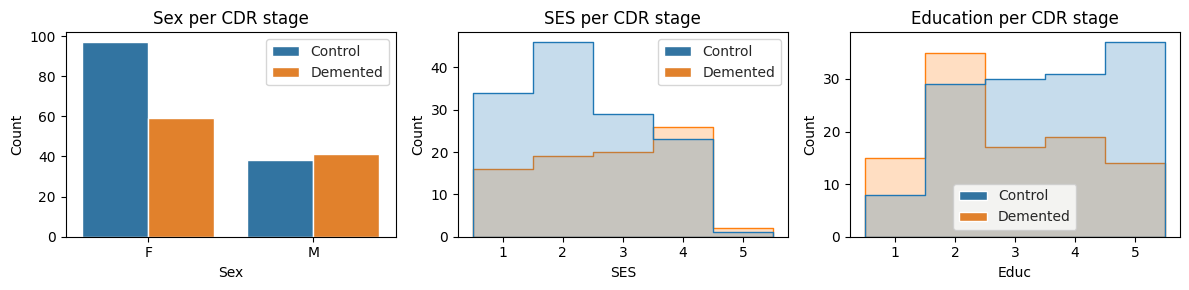

In [4]:
# Import packages for visualizations
from matplotlib import pyplot as plt
import seaborn as sns

# Create three subplots
ncol = 3
fig, axes = plt.subplots(1, ncol)

# Set the figure size
fig.set_figheight(3)
fig.set_figwidth(12)

# Set the Seaborn style to "ticks"
sns.set_style("ticks")

# Plot sex for different CDR stages
sns.countplot(df_cross, x="M/F", hue="CDR", ax=axes[0])
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Count")

# Plot SES for different CDR stages
sns.histplot(df_cross, x="SES", hue="CDR", element="step", bins=5, discrete=True, ax=axes[1])
axes[1].set_xticks(range(1, 6))

# Plot education for different CDR stages
sns.histplot(df_cross, x="Educ", hue="CDR", element="step", bins=5, discrete=True, ax=axes[2])
axes[2].set_xticks(range(1, 6))

# Add legends
handles, _ = axes[0].get_legend_handles_labels()
labels = dict(zip(["Control", "Demented"], handles))
axes[0].legend(labels.values(), labels.keys())
axes[1].legend(labels.values(), labels.keys())
axes[2].legend(labels.values(), labels.keys(), loc='lower center')

# Add titles
axes[0].set_title('Sex per CDR stage')
axes[1].set_title('SES per CDR stage')
axes[2].set_title('Education per CDR stage')

# Adjust layout
plt.tight_layout()

Boxplots show that the mean age and eTIV are slightly higher and the MMSE and nWBV are lower for demented vs. non-demented subjects. Outliers did not exceed the range of $Q_{1} - 3 * IQR$ or $Q_{3} + 3 * IQR$ and were therefore not labeled as extreme outliers and removed from the data set.

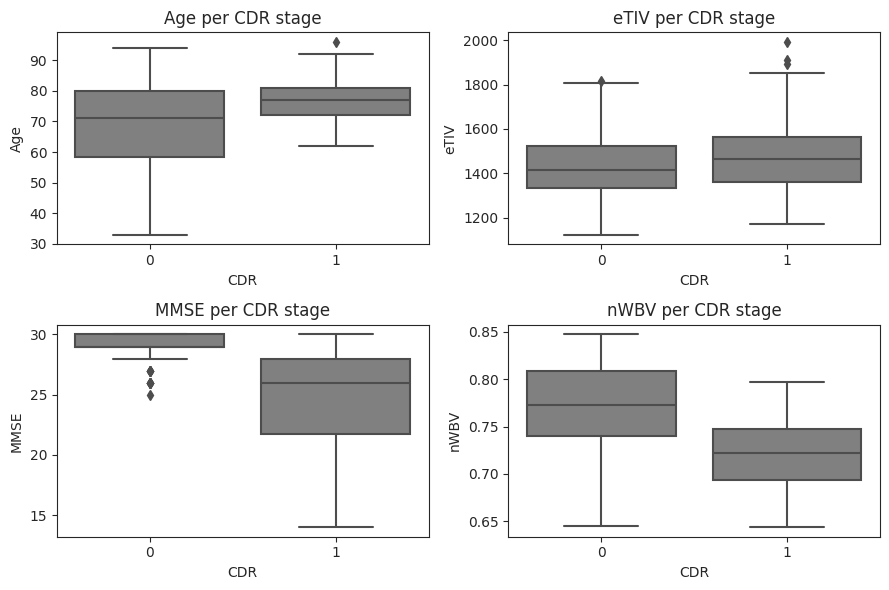

In [5]:
# Create two subplots
fig, axes = plt.subplots(2, 2)

# Set the figure size
fig.set_figheight(6)
fig.set_figwidth(9)

# Set the Seaborn style to "ticks"
sns.set_style("ticks")

# Create boxplots for CDR and various variables
sns.boxplot(df_cross, x="CDR", y="Age", color="gray", ax=axes[0, 0])
sns.boxplot(df_cross, x="CDR", y="MMSE", color="gray", ax=axes[1, 0])
sns.boxplot(df_cross, x="CDR", y="eTIV", color="gray", ax=axes[0, 1])
sns.boxplot(df_cross, x="CDR", y="nWBV", color="gray", ax=axes[1, 1])

# Add titles to each subplot
axes[0, 0].set_title('Age per CDR stage')
axes[1, 0].set_title('MMSE per CDR stage')
axes[0, 1].set_title('eTIV per CDR stage')
axes[1, 1].set_title('nWBV per CDR stage')

# Adjust layout
plt.tight_layout()

### Longitudinal dataset

In [6]:
# Group 'df_long' by "Visit" and "CDR", and get the size (count) of each group
grouped_df = df_long.groupby(["Visit", "CDR"]).size()

# Get the size (count) of each group when 'df_long' is grouped only by "Visit"
size_arr = df_long.groupby("Visit").size().values

# Create a new DataFrame 'count_df' to store the counts, 'Visit', 'CDR', and the corresponding percentage
count_df = pd.DataFrame({
    "Visit": [i[0] for i in grouped_df.index], # Extract the 'Visit' values from the multi-index
    "CDR": [i[1] for i in grouped_df.index], # Extract the 'CDR' values from the multi-index
    "Count": grouped_df.values # Extract the count values from the grouped DataFrame
})

# Calculate the percentage of each group count relative to the total count for the corresponding 'Visit'
count_df["Percentage"] = (
    count_df["Count"] / count_df["Visit"].map(lambda x: size_arr[round(x) - 1]) * 100
)

There is a large loss of participants in the longitudinal data set. The distribution of demented vs. non-demented participants per visit shows slightly fewer demented subjects per visit. The plot on the relative percentage of CDR stages per visit illustrates that the largest imbalance between CDR stages is observable at visits four and five.

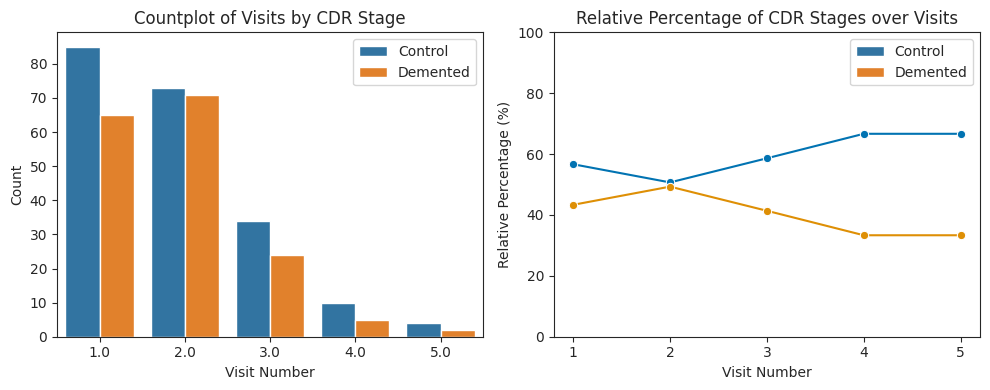

In [7]:
# Create two subplots
ncol = 2
fig, axes = plt.subplots(1, ncol)

# Set the figure size
fig.set_figheight(4)
fig.set_figwidth(10)

# Set the Seaborn style to "ticks"
sns.set_style("ticks")

# Create a countplot in the first subplot
sns.countplot(df_long, x="Visit", hue="CDR", ax=axes[0])
axes[0].set_xlabel("Visit Number")
axes[0].set_ylabel("Count")

# Create a lineplot in the second subplot
sns.lineplot(
    count_df, x="Visit", y="Percentage",
    hue="CDR", palette="colorblind",
    marker="o", ax=axes[1]
)

axes[1].set_xlabel("Visit Number")
axes[1].set_ylabel("Relative Percentage (%)")
axes[1].set_xticks(range(1, 6)) # Set x-axis ticks from 1 to 5
axes[1].set_ylim(bottom=0, top=100) # Set y-axis limits from 0 to 100

# Get legend handles and labels from the first subplot
handles, _ = axes[0].get_legend_handles_labels()
# Create a legend mapping labels to handles for both subplots
labels = dict(zip(["Control", "Demented"], handles))

# Add legends
axes[0].legend(labels.values(), labels.keys())
axes[1].legend(labels.values(), labels.keys())

# Add titles
axes[0].set_title('Countplot of Visits by CDR Stage')
axes[1].set_title('Relative Percentage of CDR Stages over Visits')

# Adjust the layout for better visualization
plt.tight_layout()

### Principal Component Analysis

In [8]:
# Import packages
from sklearn.decomposition import PCA
from scipy.stats import mode

# Label cross-sectional samples with visit 1
df["Visit"] = df["Visit"].fillna(value=1)

# Drop target, categorical variables and metadata
X = df.drop(["Delay", "Subject ID", "Group", "Visit", "M/F", "Cohort"], axis=1)
y = X.pop("CDR")

# Impute SES on the fly
X["SES"] = X["SES"].map(lambda x: mode(X["SES"])[0] if np.isnan(x) else x)
# Impute MMSE on the fly
X["MMSE"] = X["MMSE"].map(lambda x: np.nanmedian(X["MMSE"]) if np.isnan(x) else x)

# Create PCA
pca = PCA(n_components=4)
# Perform PCA
red_dims = pca.fit_transform(X)

PCA is employed to reduce dimensionality by identifying an orthonormal basis of the data (Shlens, 2014). The components are selected to maximize variance in the original dataset, with the first component capturing the most variance. In this project, PCA was implemented to identify a lower-dimensional representation of the dataset, aiming to improve computational efficiency and potentially enhance classification accuracy. The PCA analysis was conducted to derive four principal components.

The first two components are plotted below. The figure shows that the CDR data is not clearly separable which might make a non-linear classification method necessary. Sex, age and eTIV accounted for most of the variance in the data. Remarkably, confounders such as cohort and visit do not contribute to the principal components of PCA, and therefore bias is relatively small.

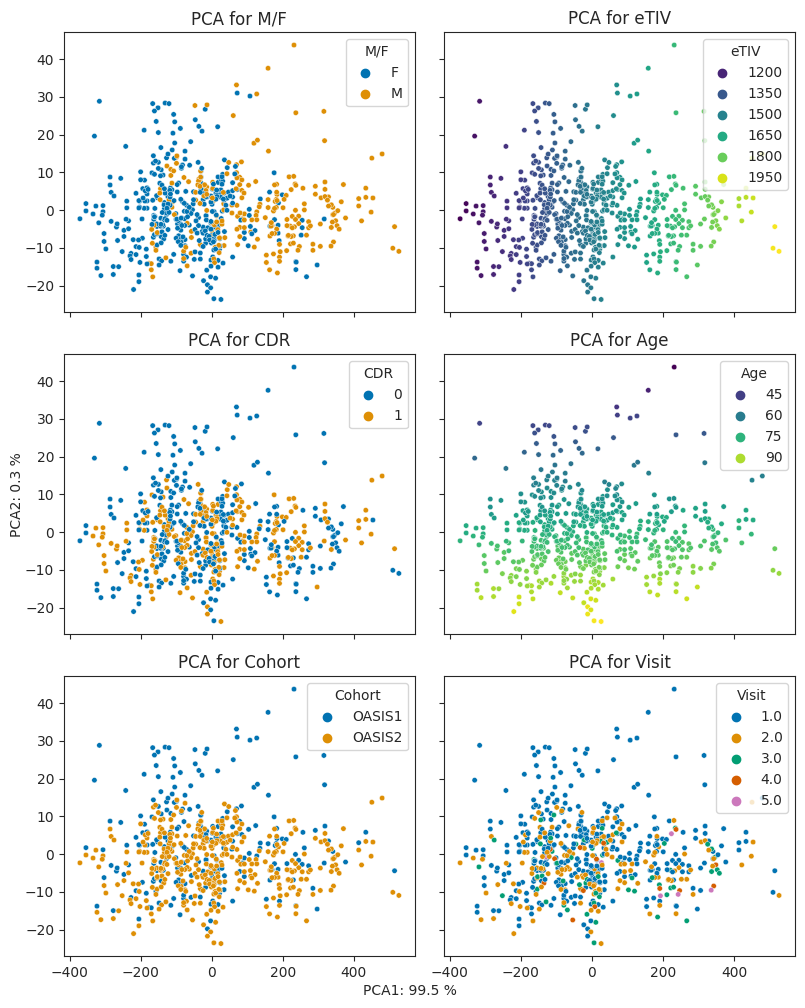

In [9]:
# Import function from the 'utilities_for_ad' script
from utilities_for_ad import plot_pca

# Define the number of columns and rows for subplots, and create a color palette
ncol, nrow = 3, 2
my_palette = sns.color_palette("viridis", as_cmap=True)

# Create subplots with shared x and y axes
fig, axes = plt.subplots(ncol, nrow, sharex=True, sharey=True)

# Set the figure size
fig.set_figheight(5 * nrow)
fig.set_figwidth(8)

# Set the Seaborn style to "ticks"
sns.set_style("ticks")

# Plot PCA for different variables in different subplots with titles
plot_pca(red_dims, df["M/F"], axes[0, 0]) # PCA for "M/F" variable
axes[0, 0].set_title("PCA for M/F") # Title for the subplot

plot_pca(red_dims, df["eTIV"], axes[0, 1], palette=my_palette) # PCA for "eTIV" variable
axes[0, 1].set_title("PCA for eTIV") # Title for the subplot

plot_pca(red_dims, df["CDR"], axes[1, 0]) # PCA for "CDR" variable
axes[1, 0].set_title("PCA for CDR") # Title for the subplot

plot_pca(red_dims, df["Age"], axes[1, 1], palette=my_palette) # PCA for "Age" variable
axes[1, 1].set_title("PCA for Age") # Title for the subplot

plot_pca(red_dims, df["Cohort"], axes[2, 0]) # PCA for "Cohort" variable
axes[2, 0].set_title("PCA for Cohort") # Title for the subplot

plot_pca(red_dims, df["Visit"], axes[2, 1]) # PCA for "Visit" variable
axes[2, 1].set_title("PCA for Visit") # Title for the subplot

# Add text annotations for explained variance ratios
fig.text(0.5, 0, f"PCA1: {pca.explained_variance_ratio_[0] * 100:.1f} %", ha="center")
fig.text(0, 0.5, f"PCA2: {pca.explained_variance_ratio_[1] * 100:.1f} %", va="center", rotation="vertical")

# Adjust the layout for better visualization
plt.tight_layout()

## Correlation Heatmap

A correlation heatmap is a commonly used method to visualize relationships between features of a data set. We inspected the relationships between variables in terms of Pearson correlation. Among others, nWBV appeared to be negatively correlated with age and positively correlated with MMSE, whereas eTIV and ASF were almost completely opposite to one another.

Text(0.5, 1.0, 'Correlation Heatmap of Features')

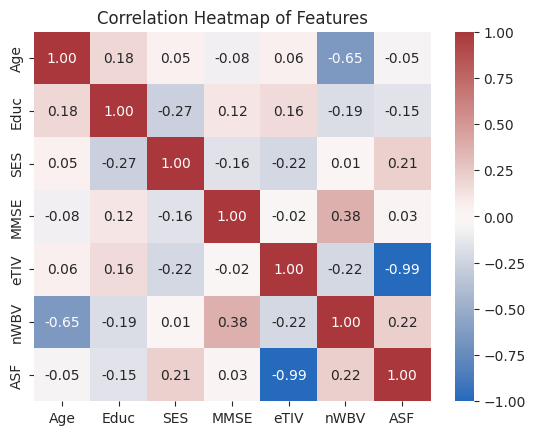

In [10]:
# Compute the correlation matrix for the features in the dataset
corr = X.corr()

# Create a heatmap using seaborn
sns.heatmap(
    corr, cmap="vlag", annot=True,  # Display the heatmap with annotation
    fmt=".2f", annot_kws={'size': 10},  # Format annotations with two decimal places
    vmin=-1, vmax=1  # Set the color scale limits to -1 and 1
)

# Add a title
plt.title("Correlation Heatmap of Features")

## Mutual Information

Mutual information refers to the “reduction in uncertainty about one variable due to the knowledge of the other variable” (Duda & Hart, 2006). It is calculated based on the entropy (H) of the variables. Discrete variables were factorised and mutual information was calculated as follows:

$I(X; Y)=H(X)-H(X|Y)$
 
The variables eTIV and MMSE turned out to be the most informative, whereas other MRI and demographic variables played a secondary role.

In [11]:
# Add sex back into variables
X["M/F"] = df["M/F"]
# Specify discrete variables
discrete_features = ["M/F", "SES", "Educ"]

# Factorise discrete variables
for col in discrete_features:
    X[col], _ = X[col].factorize()
    
# Convert type to integer
discrete_features = X.dtypes == int

Text(0.5, 1.0, 'Mutual Information of Features')

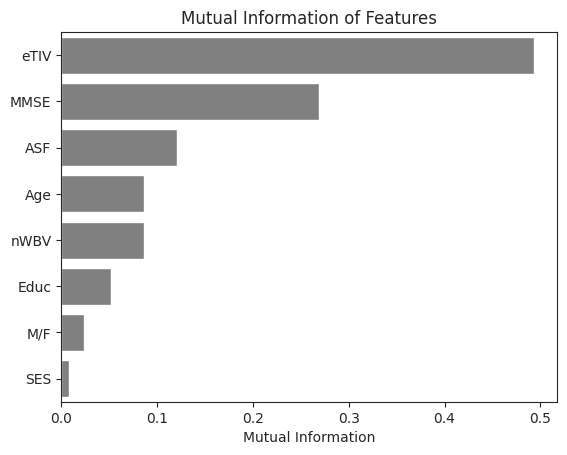

In [12]:
# Import package
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information scores
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
# Convert scores into series
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
# Sort scores by magnitude
mi_scores = mi_scores.sort_values(ascending=False)

# Visualise mutual information with barplot
sns.barplot(x=mi_scores, y=mi_scores.index, color="gray")
plt.xlabel("Mutual Information")
plt.title('Mutual Information of Features')

# Cross-Sectional Analysis

After excluding participants with missing CDR values, the OASIS-I dataset retained 235 subjects of which 156 were female.

## Preprocessing

Subsequent preprocessing involves splitting the data, allocating 90% to the training set before imputing socioeconomic status for 19 subjects to prevent information leakage. Additionally, numerical variables undergo z-score normalization, while ordinal variables are one-hot encoded.

### Train / Test Split

In [13]:
# Import packages
from utilities_for_ad import X_y_split
from sklearn import model_selection as ms

# Split X and y for cross-sectional dataset
X_cross, y_cross = X_y_split(df_cross)

# Set fraction of data allocated to the test set 
test_fraction = 0.1

# Split train/devel set from test set
X_train, X_test, y_train, y_test = ms.train_test_split(
    X_cross, y_cross,
    test_size=test_fraction,
    stratify=y_cross,
    random_state=123,
)

### Imputation

In [14]:
# Import package
from sklearn.impute import SimpleImputer

# Given a uniform distribution, impute SES with mode
ses_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")

# Apply SES imputer to data
X_train["SES"] = ses_imputer.fit_transform(X_train[["SES"]])
X_test["SES"] = ses_imputer.transform(X_test[["SES"]])

### Data normalisation

Data normalisation helps standardise features and speed up learning. Thus, numerical variables are scaled and categorical variables are one-hot encoded.

In [15]:
# Importing necessary modules
from sklearn import preprocessing
from sklearn.compose import make_column_transformer

# Categorizing variables by type
categorical_vars = ["M/F"]  # Categorical variable
numerical_vars = ["Age", "eTIV", "nWBV", "MMSE"]  # Numerical variables
ordinal_vars = ["Educ", "SES"]  # Ordinal variables

# Creating a preprocessor using make_column_transformer
preprocessor = make_column_transformer(
    (preprocessing.StandardScaler(), numerical_vars),  # Scaling numerical variables
    (preprocessing.OneHotEncoder(), categorical_vars)  # One-hot encoding categorical variables
)

# Applying the preprocessor to the training and testing data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


We also prepare a version of the train data without MMSE for benchmarking purposes.

In [16]:
# Reconstruct feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Get index of MMSE in transformed array
mmse_index = np.where(feature_names == 'standardscaler__MMSE')[0][0]

# Create train and test set without mmse
X_train_without_mmse = np.delete(X_train, mmse_index, axis=1)
X_test_without_mmse = np.delete(X_test, mmse_index, axis=1)

### Clustering

The k-means algorithm stands out as a widely employed approach for clustering data into a chosen number (k) of clusters (Hastie et al., 2019). This technique involves measuring distances between individual data points and their respective assigned cluster centers, aiming to minimize these distances within each cluster. In assessing the efficacy of the clustering process, commonly employed metrics include the elbow score and silhouette score.

The elbow score is computed as the sum of squared distances between data points and their assigned cluster centroids. Inertia is the term commonly used in scikit-learn to represent this sum of squared distances. The goal is to find the number of clusters where the inertia starts to decrease at a slower rate, forming an "elbow" in the plot. This point is often considered an optimal number of clusters. The silhouette score measures how well-separated the clusters are. It ranges from -1 to 1, where a higher score indicates better-defined clusters.

Cluster analyses using the silhouette and the elbow score indicated four clusters in our train data.

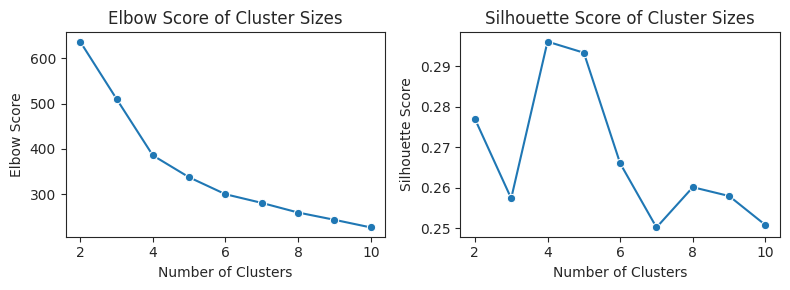

In [17]:
# Import functions and modules
from utilities_for_ad import score_cluster

# Range of cluster numbers to be evaluated
n_clusters = range(2, 11)

# Calculating clustering scores for different numbers of clusters using the score_cluster function
scores = np.array(list(map(lambda n_clusters: score_cluster(X_train, n_clusters), n_clusters)))
elbow, silhouette = scores[:, 0], scores[:, 1]

# Creating subplots for Elbow and Silhouette scores
fig, axes = plt.subplots(1, 2)

# Setting the figure size
fig.set_figheight(3)
fig.set_figwidth(8)

# Setting the Seaborn style to "ticks"
sns.set_style("ticks")

# Plotting the Elbow Score
sns.lineplot(x=n_clusters, y=elbow, marker="o", ax=axes[0])
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Elbow Score")
axes[0].set_title("Elbow Score of Cluster Sizes")

# Plotting the Silhouette Score
sns.lineplot(x=n_clusters, y=silhouette, marker="o", ax=axes[1])
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Score of Cluster Sizes")

# Adjust the layout
plt.tight_layout()

Add cluster labels as additional features to the training and testing data

In [18]:
# Importing the KMeans class
from sklearn.cluster import KMeans

# Creating a KMeans clustering model with 5 clusters and fitting it to the training data
kmeans = KMeans(n_clusters=5, random_state=123).fit(X_train)

# Extracting cluster labels for the training data
train_clusters = kmeans.labels_.reshape(-1, 1)

# Predicting cluster labels for the testing data
test_clusters = kmeans.predict(X_test).reshape(-1, 1)

# Adding cluster labels as additional features to the training and testing data
X_train = np.hstack([X_train, train_clusters])
X_test = np.hstack([X_test, test_clusters])

## Validation Performance

Currently, the criterion to select the most performant model is based on the confusion matrix and validation metrics such as accuracy, specificity, sensitivity, and precision. Accuracy gives a general measure of the classification power and is our main criterion, whereas specificity, sensitivity, and precision provide a more detailed insight into the bias of the model. It may be useful to validate the models with other metrics which put more weight on the rare classes, that is, the demented subjects.

### Implement K-fold validator

In [19]:
# Set k equal to the number of occurrences of least populated class
k_folds = 10

# Create stratified K-fold validator
skf = ms.StratifiedKFold(
    n_splits=k_folds,
    shuffle=True,
    random_state=123
)

### Establish Baseline Performance

_How can we define the minimal expected performance for a model?_ The answer lies in establishing a **baseline performance**, typically achieved by employing a straightforward model—like a classifier predicting every instance as the most frequent class. This pragmatic approach is utilized here to estimate baseline performance for both the cross-sectional and longitudinal datasets, as well as their combined counterpart.

In [20]:
from utilities_for_ad import baseline_performance
from sklearn.metrics import balanced_accuracy_score

print(f"Baseline accuracy: {baseline_performance(X_cross, y_cross, metric=balanced_accuracy_score):.2f}")

Baseline accuracy: 0.50


The baseline performance remains similar among the three datasets with an average of around 50%. This is the minimum accuracy that we want to achieve with a more suitable model.

## Model Selection

The most performant model was selected from a pool of models belonging to multiple families of classifiers. The candidate models include:

- Gaussian process
- Gradient boosting
- Linear Discriminant Analysis (LDA)
- Logistic regression
- Random forest
- Support Vector Machine (SVM)


In every algorithm that allowed it, the random seed was fixed and class imbalance was taken into account. To add a new model, you can simply import it from a package, create it and store it in the dictionary of classifiers under a name of your choice.

In [21]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Set a seed for reproducibility
seed = 123

# Use "balanced" class weights to handle imbalanced datasets
class_weight = "balanced"

# Prepare an empty dictionary to store models
models = {}

# Create Gaussian Process classifier
models["Gaussian Process"] = GaussianProcessClassifier(random_state=seed)

# Create Gradient Boosting classifier
models["Gradient Boosting"] = GradientBoostingClassifier(random_state=seed)

# Create Linear Discriminant Analysis (QDA) classifier
models["Linear Discriminant"] = LinearDiscriminantAnalysis()

# Create logistic regression classifier with balanced class weights
models["Logistic Regression"] = LogisticRegression(class_weight=class_weight)

# Create random forest classifier with balanced class weights
models["Random Forest"] = RandomForestClassifier(random_state=seed, class_weight=class_weight)

# Create Support Vector Machine (SVM) classifier with balanced class weights
models["SVM"] = SVC(random_state=seed, class_weight=class_weight)

### Add new models here ###
# models["name"] = model()

#### Training the Models & Plotting Confusion Matrices

We are training the models with default settings for an initial screening of the best candidate. Below, we are plotting the confusion matrices and balanced accuracies for each model.

In [22]:
# # Import utility functions for model validation and confusion matrix creation
from utilities_for_ad import validate_model, make_confusion_matrix

# Validate models with accuracy
acc_scores = list(map(lambda model: validate_model(model, X_train, y_train, metric=balanced_accuracy_score, cv=skf).mean(), models.values()))
acc_scores = dict(zip(models.keys(), acc_scores))

# Validate models with a confusion matrix
confusion_matrices = list(map(lambda model: make_confusion_matrix(model, X_train, y_train, cv=skf), models.values()))
confusion_matrices = dict(zip(models.keys(), confusion_matrices))

Gaussian Process    : ACC = 0.810
Gradient Boosting   : ACC = 0.808
Linear Discriminant : ACC = 0.812
Logistic Regression : ACC = 0.834
Random Forest       : ACC = 0.816
SVM                 : ACC = 0.828


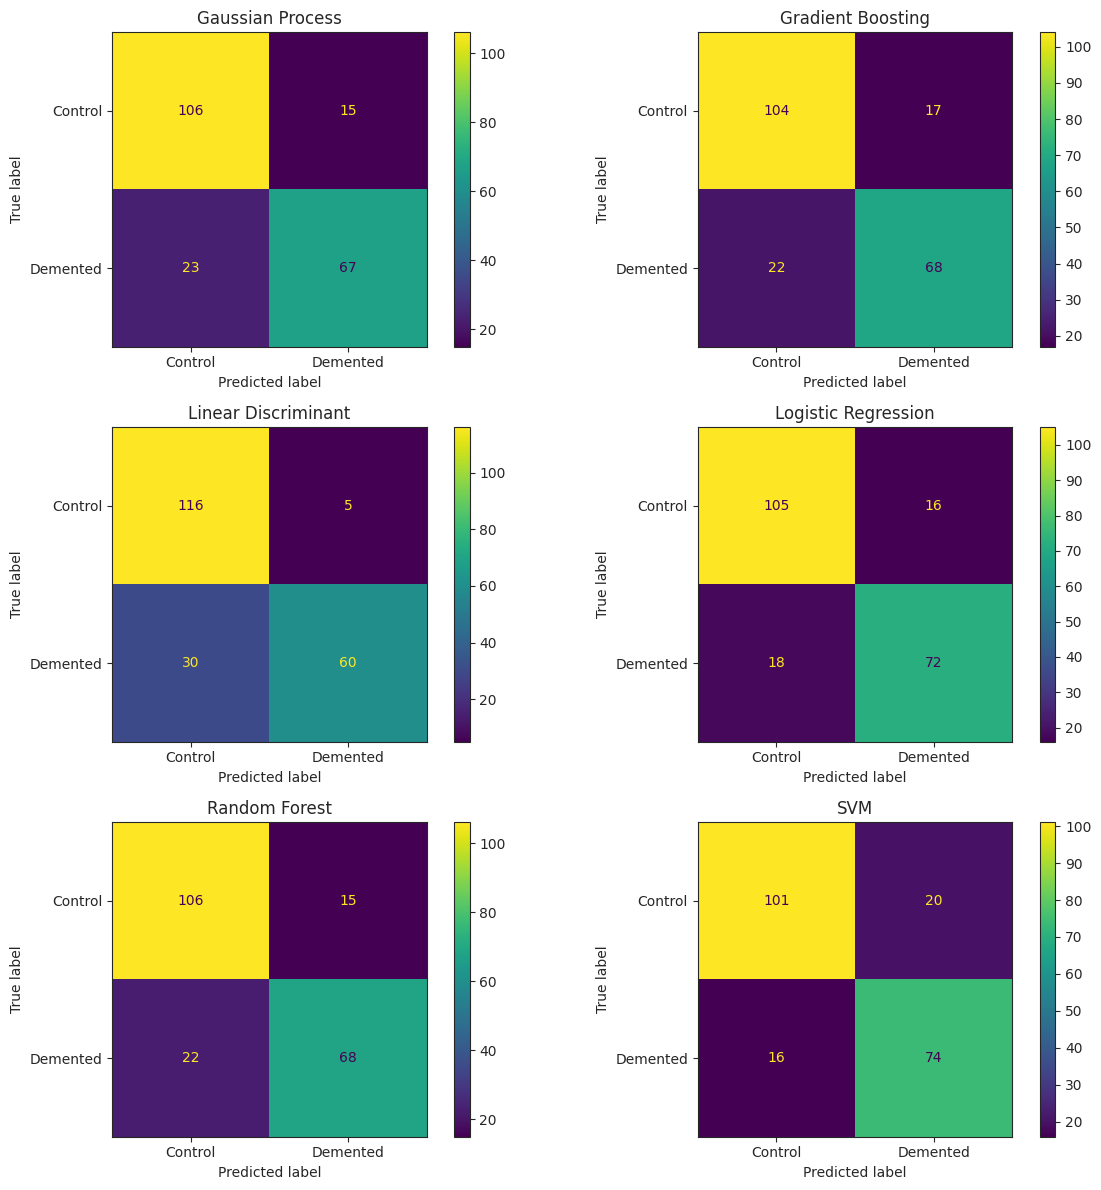

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the number of columns and calculate the number of rows needed
ncol = 2
model_num = len(models)
nrow = round(np.ceil(model_num / ncol))

# Create a subplot grid
fig, axes = plt.subplots(nrow, ncol)

# Set the figure size based on the number of rows and columns
fig.set_figheight(4 * nrow)
fig.set_figwidth(6 * ncol)

# Print validation profile for each model
for idx, (name, model) in enumerate(models.items()):
    print(f"{name:20s}: ACC = {acc_scores[name].mean():.3f}")

    # Calculate the row index
    if idx == 0:
        row_idx = 0
    elif idx % ncol == 0:
        row_idx += 1
    
    # Create ConfusionMatrixDisplay for each model and plot on the corresponding subplot
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[name], display_labels=["Control", "Demented"])
    disp.plot(ax=axes[row_idx, idx % ncol])
    disp.ax_.set_title(name)

# Adjust layout
plt.tight_layout()

## Hyperparameter Tuning

_How can we optimise the selected model to improve performance?_ The answer to this question lies in **hyperparameter tuning**. Here, the goal consists in finding the combination of values for the model hyperparameters in order to achieve the best possible performance. This is usually done with a grid search, which can be either full or randomised. The former searches over the full grid for the actual best combination, whereas the latter only searches over a random subset of the grid. Randomised grid search reduces the computational demand while still providing a nearly optimal combination of values, for which reason it is applied below.

In [24]:
# Select the best classifier algorithm
selected_key = max(acc_scores, key=acc_scores.get)
selected_model = models[selected_key]

# View the best classifier algorithm
selected_model

LogisticRegression(class_weight='balanced')

In [25]:
# Provide parameters to optimise and grid values
if selected_key == "Random Forest":
    
    param_grid = { 
        "n_estimators": [25, 50, 100, 150], 
        "max_features": ["sqrt", "log2", None], 
        "max_depth": [3, 6, 9], 
        "max_leaf_nodes": [3, 6, 9], 
    } 
    
elif selected_key == "SVM":
    
    param_grid = {
        "C": [1, 10, 100, 1000],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": [2, 3, 4, 5],
        "gamma": ["auto", "scale"]
    }

elif selected_key == "Logistic Regression":
    
    param_grid = {
        "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
        "penalty": ["none", "l1", "l2", "elasticnet"], 
        "C":[1, 1.2, 1.4, 1.6, 1.8, 2, 5, 10, 100, 1000]
    }   

#### Perform Random Search Cross Validation

In [26]:
from sklearn.metrics import make_scorer
from functools import reduce

# Convert parameter grid to list
grid_values = list(param_grid.values())
# Compute number of possible combinations (full grid)
full_search_iter = reduce(lambda x, y: x * len(y), grid_values[1:], len(grid_values[0]))

# Perform randomised search for best combination of parameters
tuned_models = ms.RandomizedSearchCV(
    estimator=selected_model,
    param_distributions=param_grid,
    n_iter=min(full_search_iter, 60), 
    scoring=make_scorer(balanced_accuracy_score),
    cv=skf,
    random_state=123
)

#### Train tuned models and display best model

In [27]:
# Train tuned models
tuned_models.fit(X_train, y_train)

# Select the best model in terms of accuracy
tuned_model = tuned_models.best_estimator_

# View the best model
tuned_model

LogisticRegression(C=1.4, class_weight='balanced', solver='newton-cg')

## Model Assessment

After selecting and tuning the best model, it is finally time to test its performance on the test set. Getting nervous, how well will it do?

In [28]:
# Predict CDR of test set with best tuned model
tuned_model.fit(X_train, y_train)
y_pred = tuned_model.predict(X_test)

# Train best model on dataset without MMSE
tuned_model.fit(X_train_without_mmse, y_train)
y_pred_no_mmse = tuned_model.predict(X_test_without_mmse)

print("Accuracy of best tuned model")
print(f"with MMSE: {balanced_accuracy_score(y_test, y_pred):.3f}")
print(f"without MMSE: {balanced_accuracy_score(y_test, y_pred_no_mmse):.3f}")

Accuracy of best tuned model
with MMSE: 0.807
without MMSE: 0.786


#### Confusion matrices of best model with / without MMSE

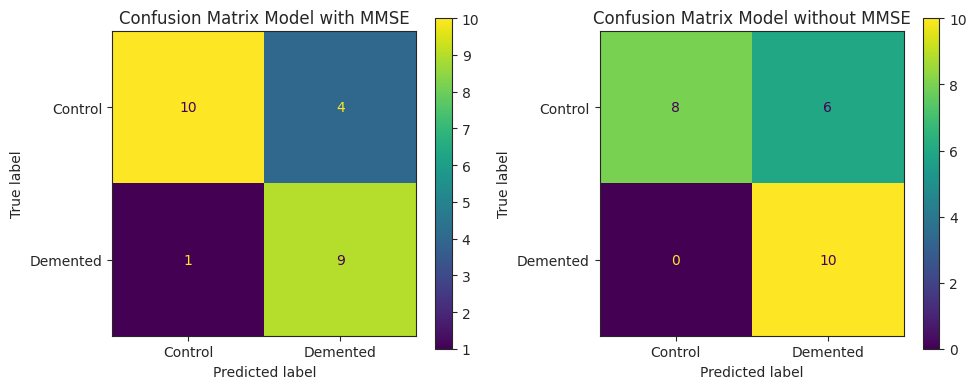

In [29]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(4)
fig.set_figwidth(10)

# Plot confusion matrix for model with MMSE
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Control", "Demented"])
disp.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix Model with MMSE")

# Plot confusion matrix for model without MMSE
cm = confusion_matrix(y_test, y_pred_no_mmse)
disp = ConfusionMatrixDisplay(cm, display_labels=["Control", "Demented"])
disp.plot(ax=axes[1])
axes[1].set_title("Confusion Matrix Model without MMSE")

plt.tight_layout()

plt.savefig('Confusion Matrices.png')

The accuracy appeared lower in the model without MMSE than in the model with MMSE. However, there were less false negatives and more false positives than before, that is, a better recall.

### Deep Learning Approach

#### Model Architecture

For the cross-sectional analysis, we built a simple three-layer feed-forward neural network for binary classification with a sequential architecture, ReLU activation and a dropout rate of 0.3 for regularisation. The design enhances stability during training, prevents overfitting, and captures non-linear relationships. 10-fold cross-validation was employed during training and testing.

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from utilities_for_ad import reproduce_environment
from tensorflow.keras.utils import plot_model

# Set input shape
input_shape = [X_train.shape[1]]

# Build model
def design_model():
    
    # Create a sequential model
    model = keras.Sequential([
        layers.BatchNormalization(),  # Batch normalization layer
        layers.Dense(4, activation="relu", input_shape=input_shape),  # Dense layer with ReLU activation
        layers.BatchNormalization(),  # Batch normalization layer
        layers.Dropout(rate=0.3),  # Dropout layer
        layers.Dense(4, activation="relu"),  # Dense layer with ReLU activation
        layers.BatchNormalization(),  # Batch normalization layer
        layers.Dropout(rate=0.3),  # Dropout layer
        layers.Dense(1, activation="sigmoid")  # Output layer with sigmoid activation
    ])

    return model

#### Implement Cross-Validation Performance Evaluation

Training spans 100 epochs with a batch size of 20.
Binary cross-entropy loss and Adam optimizer and the default learning rate of 0.001 were used.

In [31]:
# Initialise empty lists
train_accuracies = []
devel_accuracies = []

# Perform 10-fold cross-validation
for train_index, devel_index in skf.split(X_train, y_train):
    
    # Subset train and devel sets
    train_subset = X_train[train_index]
    train_labels = y_train[train_index]
    devel_subset = X_train[devel_index]
    devel_labels = y_train[devel_index]
    
    # Make environment reproducible
    reproduce_environment(random_state=123)
    
    # Build model
    model = design_model()
    
    # Compile model
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["binary_accuracy"]
    )
    
    # Train model
    history = model.fit(
        train_subset, train_labels,
        validation_data=(devel_subset, devel_labels),
        epochs=100,
        batch_size=20,
        verbose=False
    )
    
    # Fetch accuracy
    history_df = pd.DataFrame(history.history)
    
    train_accuracies.append(history_df['binary_accuracy'].iloc[-1])
    devel_accuracies.append(history_df['val_binary_accuracy'].iloc[-1])
    
    print(f"Train accuracy: {train_accuracies[-1]:.3f}, Devel accuracy: {devel_accuracies[-1]:.3f}")  

Train accuracy: 0.709, Devel accuracy: 0.727
Train accuracy: 0.679, Devel accuracy: 0.714
Train accuracy: 0.668, Devel accuracy: 0.762
Train accuracy: 0.663, Devel accuracy: 0.810
Train accuracy: 0.647, Devel accuracy: 0.810
Train accuracy: 0.663, Devel accuracy: 0.810
Train accuracy: 0.684, Devel accuracy: 0.714
Train accuracy: 0.689, Devel accuracy: 0.810
Train accuracy: 0.700, Devel accuracy: 0.667
Train accuracy: 0.684, Devel accuracy: 0.714


#### Model Training and Evaluation

In [32]:
# Make environment reproducible
reproduce_environment(random_state=123)

# Build model
model = design_model()
    
# Compile model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["binary_accuracy"]
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=20,
    verbose=False
)

history_df = pd.DataFrame(history.history)
print(f"Train accuracy: {history_df['binary_accuracy'].iloc[-1]:.3f}, Test accuracy: {history_df['val_binary_accuracy'].iloc[-1]:.3f}")

Train accuracy: 0.787, Test accuracy: 0.708


Train and loss and accuracy reached a plateau after about 150 epochs. Training was performed for 200 epochs to ensure stability of the final weights. The plots below depict predictive performance on the train set in blue and the test set in orange, respectively.

Text(0.5, 1.0, 'Accuracy over Epochs')

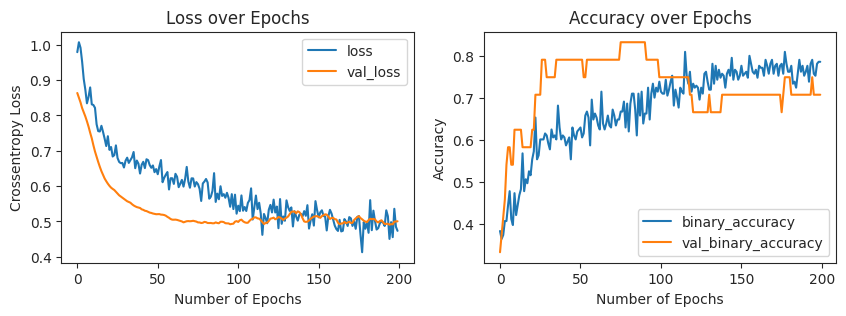

In [33]:
# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2)

# Set the figure size
fig.set_figheight(3)
fig.set_figwidth(10)

# Visualize the training and validation loss
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axes[0])
axes[0].set_xlabel("Number of Epochs")
axes[0].set_ylabel("Crossentropy Loss")
axes[0].set_title("Loss over Epochs")

# Visualize the training and validation accuracy
history_df.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot(ax=axes[1])
axes[1].set_xlabel("Number of Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy over Epochs")

#### Plot confusion matrix for deep learning approach

1/1 [==============================] - 0s 107ms/step
Accuracy of the neural network: 0.736


Text(0.5, 1.0, 'Confusion Matrix for Test Data')

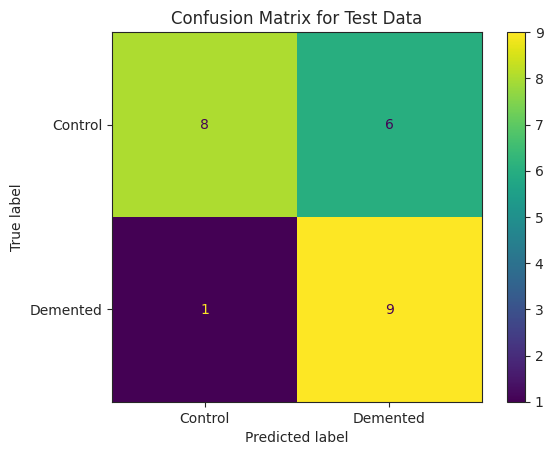

In [34]:
# Predict labels using the trained neural network
y_pred = model.predict(X_test) >= 0.5
y_pred = y_pred.astype(int)

# Evaluate and print the accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy of the neural network: {accuracy:.3f}")

# Plot confusion matrix
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=["Control", "Demented"])
confusion_matrix_display.plot()
plt.title("Confusion Matrix for Test Data")

## Conclusions

Logistic regression performed best on 10-fold cross-validation with a mean balanced accuracy of 83.4%, even though it showed a wide interquartile range. Therefore, the logistic regression classifier was optimised on the development dataset by randomised grid search cross validation and then evaluated on the test set.

In [35]:
# Calculate balanced accuracy scores for each model using 10-fold cross-validation
acc_scores = list(map(lambda model: validate_model(model, X_train, y_train, metric=balanced_accuracy_score, cv=skf), models.values()))

# Create a DataFrame to store evaluation results
eval_df = pd.DataFrame(acc_scores, index=models.keys())

# Add neural network accuracy to the DataFrame
eval_df.loc[len(eval_df)] = devel_accuracies
eval_df.rename(index={len(eval_df) - 1: "Neural Network"}, inplace=True)

# Reshape the DataFrame for visualization
eval_df["Classifier"] = eval_df.index
eval_df = pd.melt(eval_df, id_vars="Classifier", value_vars=range(k_folds))

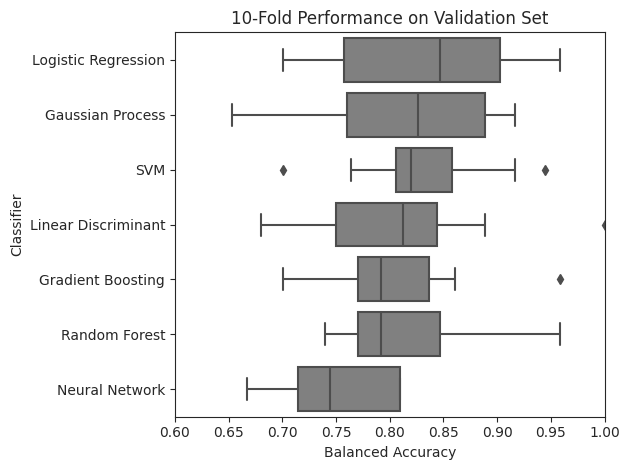

In [36]:
# Calculate and sort the medians of balanced accuracy for each classifier
medians = eval_df.groupby(["Classifier"])["value"].median().sort_values(ascending=False)

# Create a boxplot for visualizing classifier performance
sns.boxplot(eval_df, y="Classifier", x="value", color="gray", order=medians.index)

# Set plot title, limits, and labels
plt.title("10-Fold Performance on Validation Set")
plt.xlim([0.6, 1])
plt.xlabel("Balanced Accuracy")

plt.tight_layout()

# Longitudinal Analysis

In this part of the notebook, we implement a Long-Short Term Memory (LSTM) network to predict a patient's CDR from the data obtained in their previous visits, which results in a train balanced accuracy of 85% and a test balanced accuracy of 80%.

## Preprocessing

The data was preprocessed so that only sequential features are included in the samples. Because all samples need a value for each time point, missing values were forward-filled from the value of the previous visit. A few preprocessed samples can be viewed below.

In [37]:
# Convert visit variable to string
df_long["Visit"] = df_long["Visit"].astype(str)

# List sequential features
changing_vars = ["Age", "MMSE", "eTIV", "nWBV", "ASF", "CDR"]
# List constant features
stable_vars = ["M/F", "SES", "Educ"]

# Pivot dataframe along subject ID
X = df_long.pivot(
    index="Subject ID",
    columns="Visit",
    values=changing_vars
)

# Reset index and forward fill missing data
X = X.reset_index().ffill(axis=1)

# Rename columns for easy indexing
X.columns = [" ".join(col).strip(".0| ") for col in X.columns.values]
# Use subject ID as index
X.index = X.pop("Subject ID")

# Print head of dataframe
X.head()

,Age 1,Age 2,Age 3,Age 4,Age 5,MMSE 1,MMSE 2,MMSE 3,MMSE 4,MMSE 5,...,ASF 1,ASF 2,ASF 3,ASF 4,ASF 5,CDR 1,CDR 2,CDR 3,CDR 4,CDR 5
Subject ID,,,,,,,,,,,,,,,,,,,,,
OAS2_0001,87.0,88.0,88.0,88.0,88.0,27.0,30.0,30.0,30.0,30.0,...,0.883,0.876,0.876,0.876,0.876,0.0,0.0,0.0,0.0,0.0
OAS2_0002,75.0,76.0,80.0,80.0,80.0,23.0,28.0,22.0,22.0,22.0,...,1.046,1.01,1.034,1.034,1.034,1.0,1.0,1.0,1.0,1.0
OAS2_0004,88.0,90.0,90.0,90.0,90.0,28.0,27.0,27.0,27.0,27.0,...,1.444,1.462,1.462,1.462,1.462,0.0,0.0,0.0,0.0,0.0
OAS2_0005,80.0,83.0,85.0,85.0,85.0,28.0,29.0,30.0,30.0,30.0,...,1.039,1.032,1.033,1.033,1.033,0.0,1.0,0.0,0.0,0.0
OAS2_0007,71.0,71.0,73.0,75.0,75.0,28.0,28.0,27.0,27.0,27.0,...,1.293,1.293,1.286,1.279,1.279,1.0,1.0,1.0,1.0,1.0


Next, we reshape the dataset so that every element is a matrix where rows represent time points and columns represent features. The sequence containing the target variable was then separated from the matrix of features.

In [38]:
# Set the length of the time series
n_timepoints = 5

# Reshape dataframe so that every element is a matrix where
# rows represent time points and columns represent features
ds = X.to_numpy().reshape(-1, len(changing_vars), n_timepoints)
ds = np.transpose(ds, (0, 2, 1))

# Fetch features
X = ds[:, :, :-1].astype("float32")
# Fetch target variable
y = ds[:, :, n_timepoints].astype(int)

print("Sample feature sequence:")
print(X[0])
print("\n")
print("Sample target sequence:")
print(y[0])

Sample feature sequence:
[[8.700e+01 2.700e+01 1.987e+03 6.960e-01 8.830e-01]
 [8.800e+01 3.000e+01 2.004e+03 6.810e-01 8.760e-01]
 [8.800e+01 3.000e+01 2.004e+03 6.810e-01 8.760e-01]
 [8.800e+01 3.000e+01 2.004e+03 6.810e-01 8.760e-01]
 [8.800e+01 3.000e+01 2.004e+03 6.810e-01 8.760e-01]]


Sample target sequence:
[0 0 0 0 0]


### Train / Devel Set Split
The data was split into a train/devel and a test set. The latter was formed with 10% of samples. The number of visit varied between two and five and thus it was used for stratification.

In [39]:
# Count number of visits for each subject
visit_count = df_long.groupby("Subject ID")["Visit"].nunique().to_numpy()

# Split data into train/devel and test sets
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y,
    test_size=0.1,
    stratify=visit_count,
    random_state=123
)

# Compute mean of features in train set
train_mean = X_train.reshape(-1, 5).mean(axis=0)
# Compute standard deviation of features in train set
train_std = X_train.reshape(-1, 5).std(axis=0)

# Normalise train set
X_train = (X_train - train_mean) / train_std
# Normalise test set
X_test = (X_test - train_mean) / train_std

input_shape = X_train[0].shape

print(f"Size of train set: {len(X_train)}")
print(f"Size of test set: {len(X_test)}")
print(f"Input shape: {input_shape}")

Size of train set: 135
Size of test set: 15
Input shape: (5, 5)


## Prediction

We designed a relatively small LSTM model with one recurrent layer made of 20 units. 
Binary cross-entropy loss and Adam optimizer and the default learning rate of 0.001 were used. Such design allows to use all information from the previous timepoints predict CDR at a given timepoint.

### Model Implementation

In [40]:
# Make environment reproducible
reproduce_environment(random_state=123)

# Design LSTM model with one recurrent layer
model = keras.Sequential([
    layers.LSTM(20, return_sequences=True),
    layers.Dense(1, activation="sigmoid")
])

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

### Model Training
Training spans 150 epochs with a batch size of 30. The model was trained until convergence was achieved, which returned a satisfactory performance of 85% train accuracy and 80% test accuracy.

In [41]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=30,
    verbose=False
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Test loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['binary_accuracy'].iloc[-1]:.3f}, Test accuracy: {history_df['val_binary_accuracy'].iloc[-1]:.3f}")

Train loss: 0.362, Test loss: 0.464
Train accuracy: 0.850, Test accuracy: 0.800


From the loss curve, the model appeared to slightly overfit, for which reason more data should be used or regularisation should be implemented. The former solution is especially appropriate in our case, because the model in its current state is not fed with constant features such as sex, education and SES. Adding them to the input will likely improve the predictive performance of the model.

#### Loss / Accuracy over Epochs

Text(0.5, 1.0, 'Accuracy over Epochs')

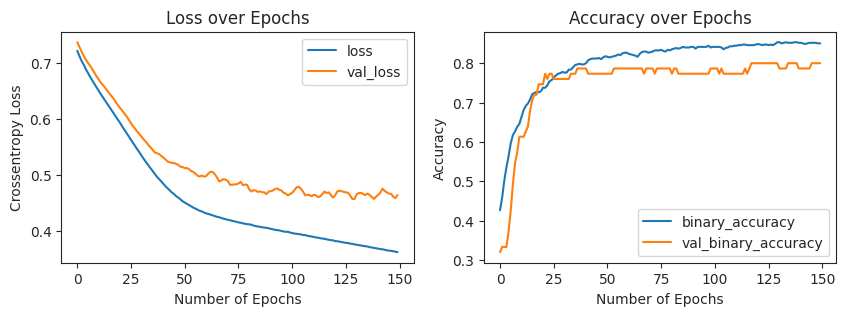

In [42]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise performance
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axes[0])
axes[0].set_xlabel("Number of Epochs")
axes[0].set_ylabel("Crossentropy Loss")
axes[0].set_title("Loss over Epochs")

history_df.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot(ax=axes[1])
axes[1].set_xlabel("Number of Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy over Epochs")

## Results

### Confusion Matrix of LSTM on test data

1/1 [==============================] - 0s 321ms/step
Accuracy of neural network: 0.808


Text(0.5, 1.0, 'Confusion Matrix LSTM')

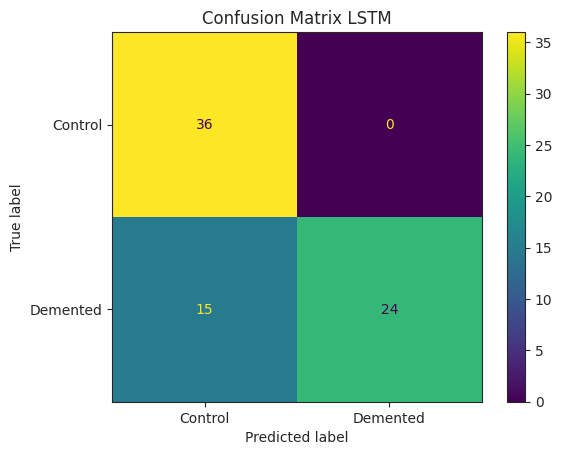

In [43]:
# Predict labels
y_pred = model.predict(X_test) >= 0.5
y_pred = y_pred.astype(int).reshape(-1, 1)

flat_y_test = y_test.reshape(-1, 1)

print(f"Accuracy of neural network: {balanced_accuracy_score(flat_y_test, y_pred):.3f}")

# Plot confusion matrix
cm = confusion_matrix(flat_y_test, y_pred)
dist = ConfusionMatrixDisplay(cm, display_labels=["Control", "Demented"])
dist.plot()
plt.title('Confusion Matrix LSTM')

### Heatmap of Results

Rows and columns represent subjects and time points, respectively. Cells are coloured by outcome of prediction and annotated with their true CDR labels.

In [44]:
from numpy.matlib import repmat

# Store true and predicted labels in dataframe
test_df = pd.DataFrame(np.hstack([flat_y_test, y_pred]), columns=["true", "pred"])

# Add columns for subject, timepoint and prediction outcome
test_df["Subject"] = np.arange(1, 16).repeat(n_timepoints)
test_df["Timepoint"] = repmat(np.arange(1, 6), 1, 15).T
test_df["Diff"] = test_df["true"] - test_df["pred"]

# Rearrange prediction outcome into colour matrix
diff_mat = pd.pivot_table(test_df, values="Diff",index=["Subject"], columns=["Timepoint"])
# Rearrange true labels into annotation matrix
cdr_mat = pd.pivot_table(test_df, values="true", index=["Subject"], columns=["Timepoint"])


Text(0.5, 1.0, 'Predictions on Test Set')

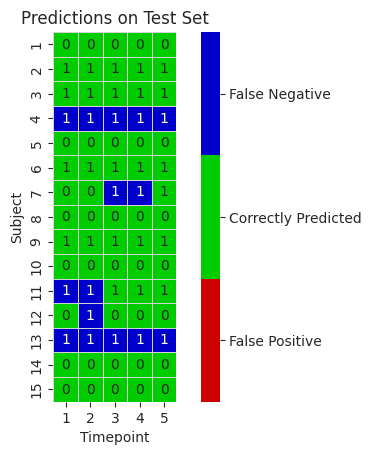

In [45]:
from matplotlib.colors import LinearSegmentedColormap

# Define custom colour map
my_colours = ((0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', my_colours, len(my_colours))

# Plot heatmap
p = sns.heatmap(
    diff_mat, square=True,
    vmin=-1, vmax=1,
    cmap=cmap, annot=cdr_mat,
    linewidths=0.5, linecolor='lightgray')

# Specify colour bar manually
colorbar = p.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(["False Positive", "Correctly Predicted", "False Negative"])

plt.title("Predictions on Test Set")

## Next steps

Overall, an LSTM network seemed a promising method for longituinal prediction of AD. However, the current model is not cross-validated or optimised, and it does not use constant features to make predictions. Given such limitations, it is highly likely that solving such issues will further improve predictive performance.

# References

Duda, R. O., & Hart, P. E. (2006). Pattern classification. John Wiley & Sons.

Hastie, T., Tibshirani, R., Friedman, J. H., & Friedman, J. H. (2009). The elements of statistical learning: data mining, inference, and prediction (Vol. 2, pp. 1-758). New York: Springer.

Marcus, D. S., Wang, T. H., Parker, J., Csernansky, J. G., Morris, J. C., & Buckner, R. L. (2007). Open Access Series of Imaging Studies (OASIS): cross-sectional MRI data in young, middle aged, nondemented, and demented older adults. Journal of cognitive neuroscience, 19(9), 1498-1507.

Marcus, D. S., Fotenos, A. F., Csernansky, J. G., Morris, J. C., & Buckner, R. L. (2010). Open access series of imaging studies: longitudinal MRI data in nondemented and demented older adults. Journal of cognitive neuroscience, 22(12), 2677-2684.

Shlens, J. (2014). A tutorial on principal component analysis. arXiv preprint arXiv:1404.1100.
